# 3- Check if any other rescaling of data or initialization of weights may improve the accuracy of the DNN.

In [1]:
import tensorflow        as tf
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns

import time

%load_ext autoreload
%autoreload 1
%aimport nn_model
%aimport create_data
%aimport preprocess
%aimport plot_utils

## Generate data

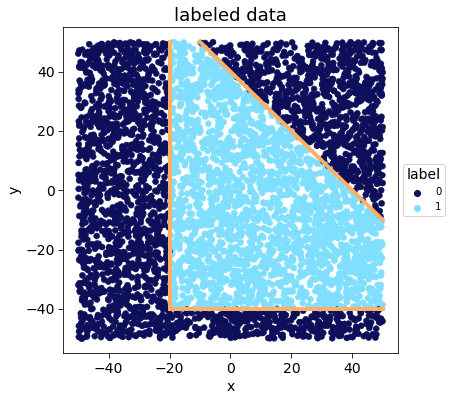

In [32]:
# number of data
N = 5000
# box size
B = 100

# random seed for reproducibility
np.random.seed(20220308)

x, y_true = create_data.create_data(N, B, c="triang")

fig = plt.figure(figsize=(6,6))
ax  = plot_utils.plot_labeled_data(
    x               = x, 
    labels          = y_true, 
    fig             = fig, 
    title           = "labeled data", 
    fontsize        = 14, 
    show_boundaries = True
)

plt.show()

## Data rescalings

Rescaling functions can be found in ```preprocess.py```

1) No rescaling
2) Standardization
3) Normalization

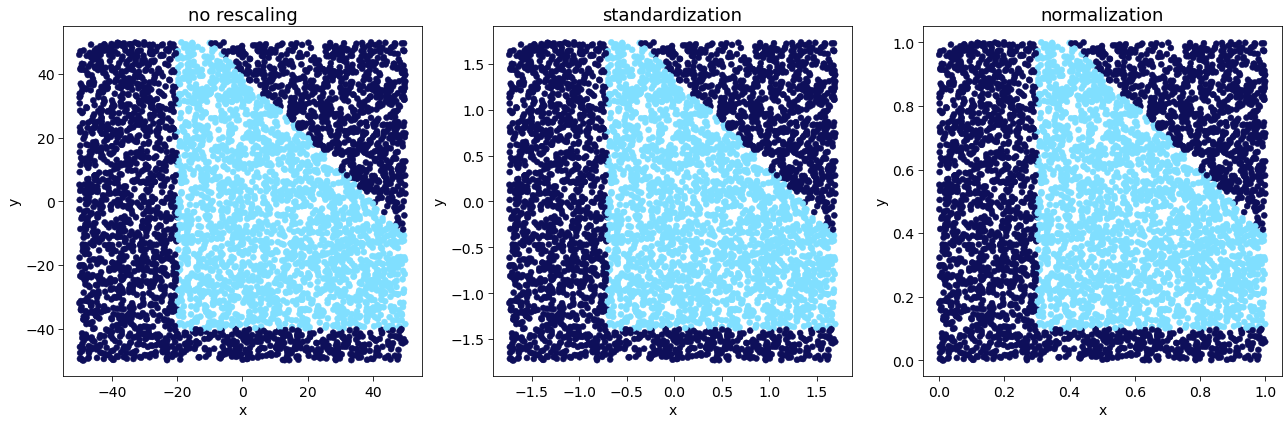

In [3]:
mean = np.mean(x, axis=0) 
std  = np.std(x, axis=0)

# no rescaling
x_nr   = np.copy(x)
# standardization
x_std  = preprocess.standardize(x, mean, std)
# normalization
x_norm = preprocess.normalize(x)

dataset = np.array([x_nr, x_std, x_norm])
titles  = ["no rescaling", "standardization", "normalization"]

fig = plt.figure(figsize=(18,6))

for i, data in enumerate(dataset):
    ax  = plot_utils.plot_labeled_data(
        x               = data, 
        labels          = y_true, 
        fig             = fig, 
        subplot_id      = 131+i,
        title           = titles[i], 
        fontsize        = 14, 
        legend          = False 
    )
plt.show()

### Training, test, validation

In [4]:
train_test_frac  = 0.7
valid_train_frac = 0.2 

N_train = int(N*train_test_frac*(1-valid_train_frac))
N_valid = int(N*train_test_frac*valid_train_frac)
N_test  = int(N*(1-train_test_frac))

train_idx = N_train
valid_idx = N_train + N_valid
test_idx  = N_train + N_valid + N_test

data_split = {
    "training_set"   : N_train,
    "test_set"       : N_test,
    "validation_set" : N_valid
}

for key, val in data_split.items():
    print(f"{key} \t N = {val}")

training_set      = []
training_labels   = []
test_set          = []
test_labels       = []
validation_set    = []
validation_labels = []

for data in dataset:

    training_set.append(data[0:train_idx])
    training_labels.append(y_true[0:train_idx])

    validation_set.append(data[train_idx:valid_idx])
    validation_labels.append(y_true[train_idx:valid_idx])

    test_set.append(data[valid_idx:test_idx])
    test_labels.append(y_true[valid_idx:test_idx])


training_set 	 N = 2800
test_set 	 N = 1500
validation_set 	 N = 700


### Quick check on training, test, validation sets

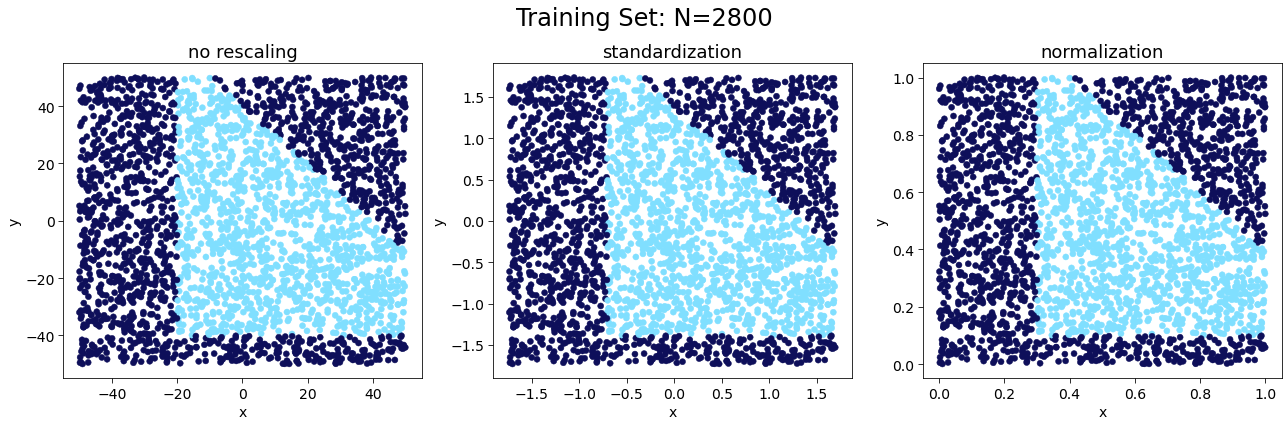

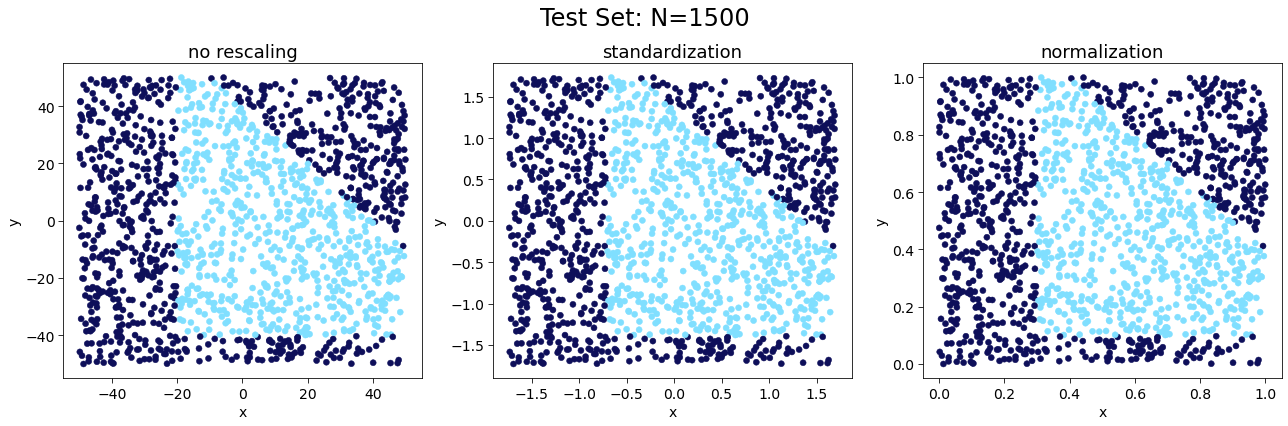

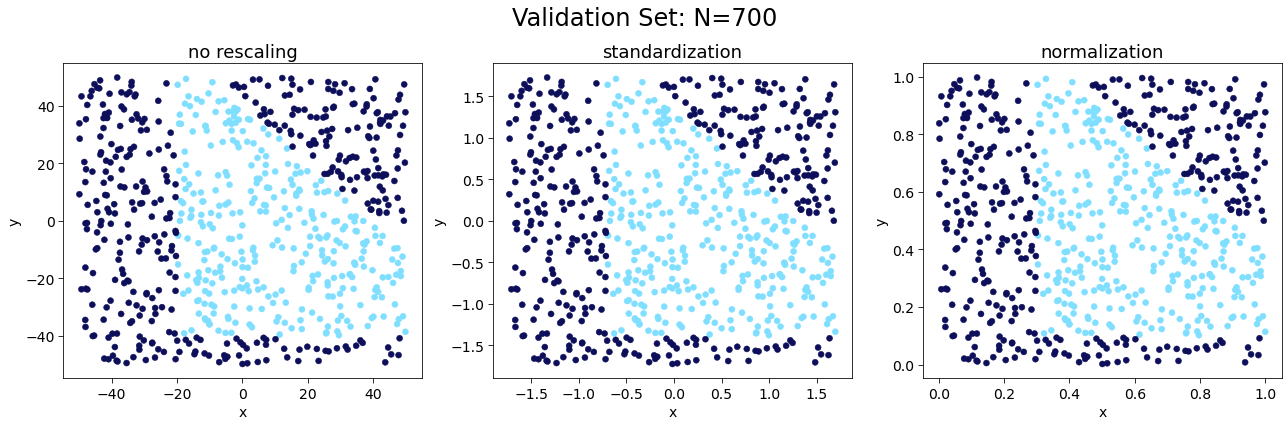

In [5]:
fig = plt.figure(figsize=(18,6))
fig.suptitle(f"Training Set: N={N_train}", fontsize=24)

for i, data in enumerate(training_set):
    ax  = plot_utils.plot_labeled_data(
        x               = data, 
        labels          = training_labels[i], 
        fig             = fig, 
        subplot_id      = 131+i,
        title           = titles[i], 
        fontsize        = 14, 
        legend          = False 
    )
plt.show()

fig = plt.figure(figsize=(18,6))
fig.suptitle(f"Test Set: N={N_test}", fontsize=24)

for i, data in enumerate(test_set):
    ax  = plot_utils.plot_labeled_data(
        x               = data, 
        labels          = test_labels[i], 
        fig             = fig, 
        subplot_id      = 131+i,
        title           = titles[i], 
        fontsize        = 14, 
        legend          = False 
    )
plt.show()

fig = plt.figure(figsize=(18,6))
fig.suptitle(f"Validation Set: N={N_valid}", fontsize=24)

for i, data in enumerate(validation_set):
    ax  = plot_utils.plot_labeled_data(
        x               = data, 
        labels          = validation_labels[i], 
        fig             = fig, 
        subplot_id      = 131+i,
        title           = titles[i], 
        fontsize        = 14, 
        legend          = False 
    )
plt.show()

### Neural network hyper-parameters

In [6]:
N_features = x.shape[1]

## NN hyperparameter

architecture      = [N_features, 20, 20, 1]
dropout_arc       = None # [1]
dropout_rates     = None # [0.2]
batch_norm_arc    = None # [2]   
input_dim         = architecture[0]
hidden_activation = "relu"
output_activation = "sigmoid"
name              = "my lovely neural network"

loss      = "binary_crossentropy"
optimizer = "adam"
metrics   = ["accuracy"]

### Training

In [7]:
# training parameters
minibatch = 100
N_epochs  = 300

networks    = []
fit_results = []

for i in range(len(dataset)):

    name = f"{titles[i]} network"

    network = nn_model.create_model(
        input_dim         = input_dim,
        architecture      = architecture,
        dropout_layers    = dropout_arc,
        dropout_rates     = dropout_rates,
        batch_norm_layers = batch_norm_arc,
        hidden_activation = hidden_activation,
        output_activation = output_activation,
        loss              = loss,
        optimizer         = optimizer,
        metrics           = metrics,
        nn_name           = name,
    )

    # network.summary()

    t0 = time.time()
    fit = network.fit(
        training_set[i], training_labels[i],
        epochs          = N_epochs,
        batch_size      = minibatch,
        validation_data = (validation_set[i], validation_labels[i]),
        verbose         = 0,
    )
    t1 = time.time()

    test = network.evaluate(
        test_set[i], test_labels[i],
        batch_size      = minibatch,
        verbose         = 0,
    )


    print("="*30)
    print(f"\n{titles[i]} training : {t1-t0:.2f} seconds\n")

    print(f"training accuracy : {fit.history['accuracy'][-1]:.5f}")
    print(f"training loss     : {fit.history['loss'][-1]:.5f}")
    print(f"valid accuracy    : {fit.history['val_accuracy'][-1]:.5f}")
    print(f"valid loss        : {fit.history['val_loss'][-1]:.5f}\n")

    print(f"\n{titles[i]} testing\n")

    print(f"test accuracy : {test[1]:.5f}")
    print(f"test loss     : {test[0]:.5f}")

    print("="*30)

    networks.append(network)
    fit_results.append(fit)


no rescaling training : 43.03 seconds

training accuracy : 0.99036
training loss     : 0.03214
valid accuracy    : 0.99429
valid loss        : 0.03044


no rescaling testing

test accuracy : 0.98533
test loss     : 0.03718

standardization training : 82.63 seconds

training accuracy : 0.99714
training loss     : 0.01496
valid accuracy    : 0.99714
valid loss        : 0.01324


standardization testing

test accuracy : 0.99667
test loss     : 0.01638

normalization training : 24.68 seconds

training accuracy : 0.99357
training loss     : 0.02404
valid accuracy    : 1.00000
valid loss        : 0.01828


normalization testing

test accuracy : 0.99933
test loss     : 0.02236


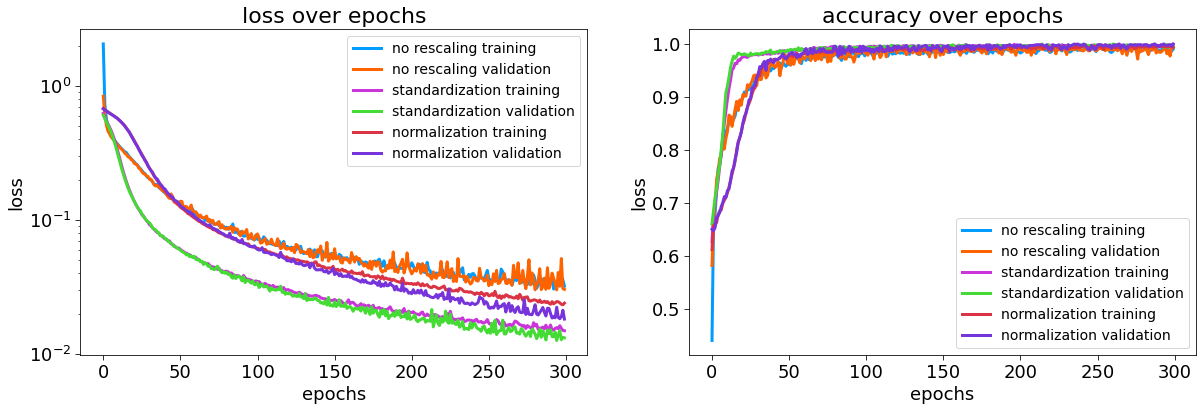

In [8]:
palette = {
    "no rescaling"   : ["#009cff", "#ff6300"],
    "standardization": ["#cb34db", "#44db34"],
    "normalization"  : ["#db3444", "#7834db"]
}

fig = plt.figure(figsize=(18,6))

ax1 = fig.add_subplot(121)

for i, fit in enumerate(fit_results):

    ax1 = plot_utils.plot_loss(
        epochs = N_epochs,
        loss   = fit.history["loss"],
        fig    = fig,
        ax     = ax1,
        color  = palette[titles[i]][0],
        title  = "loss over epochs",
        label  = f"{titles[i]} training",
    )
    ax1 = plot_utils.plot_loss(
        epochs = N_epochs,
        loss   = fit.history["val_loss"],
        fig    = fig,
        ax     = ax1,
        color  = palette[titles[i]][1],
        title  = "loss over epochs",
        label  = f"{titles[i]} validation",
    )

ax1.set_yscale("log")

ax2 = fig.add_subplot(122)

for i, fit in enumerate(fit_results):

    ax2 = plot_utils.plot_loss(
        epochs = N_epochs,
        loss   = fit.history["accuracy"],
        fig    = fig,
        ax     = ax2,
        color  = palette[titles[i]][0],
        title  = "accuracy over epochs",
        label  = f"{titles[i]} training",
    )
    ax2 = plot_utils.plot_loss(
        epochs = N_epochs,
        loss   = fit.history["val_accuracy"],
        fig    = fig,
        ax     = ax2,
        color  = palette[titles[i]][1],
        title  = "accuracy over epochs",
        label  = f"{titles[i]} validation",
    )

ax2.set_yscale("linear")

plt.show()

### Neural network predictions

In [11]:
grid = create_data.create_grid(B=B, dx=2)

grid_nr   = np.copy(grid)
grid_std  = preprocess.standardize(grid, np.mean(grid, axis=0), np.std(grid, axis=0))
grid_norm = preprocess.normalize(grid)

grids = np.array([grid_nr, grid_std, grid_norm])

In [43]:
predictions        = []
binary_predictions = []

for i in range(len(dataset)):

    y_pred = networks[i].predict(grids[i])
    predictions.append(plot_utils.flatten(y_pred))

    pred_binary = y_pred.copy()
    pred_binary[y_pred <= 0.5] = 0
    pred_binary[y_pred >  0.5] = 1
    binary_predictions.append(plot_utils.flatten(pred_binary))

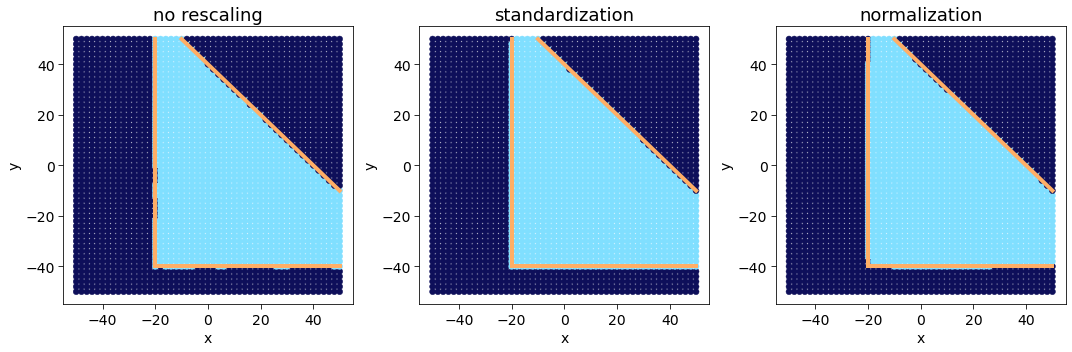

In [51]:
fig = plt.figure(figsize=(15,5))

for i in range(len(dataset)):

    ax  = plot_utils.plot_labeled_data(
        x               = grid_nr, 
        labels          = binary_predictions[i], 
        fig             = fig, 
        subplot_id      = 131+i,
        title           = titles[i], 
        fontsize        = 14, 
        legend          = False 
    )
    plot_utils.boundaries(ax)

plt.show()

## Weights initializers

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=452e6836-b7b8-455e-80d9-d4109b6baddf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>